# An example how to check different types of group commutator rotations


In [1]:
import json
import time
from pathlib import Path

import numpy as np
import qibo
from qibo import hamiltonians, set_backend
qibo.set_backend("numpy")
from boostvqe.models.dbi.double_bracket import (
    DoubleBracketGeneratorType,
    DoubleBracketIteration,
    )

from boostvqe.models.dbi.group_commutator_iteration_transpiler import *
from boostvqe.models.dbi.double_bracket_evolution_oracles import *

from boostvqe.ansatze import VQE, build_circuit
from boostvqe.utils import apply_dbi_steps, rotate_h_with_vqe
from qibo import symbols, hamiltonians
from copy import deepcopy
from boostvqe.compiling_XXZ import *

import matplotlib.pyplot as plt

[Qibo 0.2.9|INFO|2024-06-18 22:39:19]: Using numpy backend on /CPU:0


#### 1. Loading VQE results

In [2]:
def print_vqe_comparison_report(gci):
    gci_loss = gci.loss()
    print(f"VQE energy is {round(gci.vqe_energy,5)} and the DBQA yields {round(gci_loss,5)}. \n\
The target energy is {round(gci.h.target_energy,5)} which means the difference is for VQE \
    {round(gci.vqe_energy-gci.h.target_energy,5)} and of the DBQA {round(gci_loss-gci.h.target_energy,5)} which can be compared to the spectral gap {round(gci.h.gap,5)}.\n\
The relative difference is for VQE {round(abs(gci.vqe_energy-gci.h.target_energy)/abs(gci.h.target_energy)*100,5)}% \
    and for DBQA {round(abs(gci_loss-gci.h.target_energy)/abs(gci.h.target_energy)*100,5)}%.\
The energetic fidelity witness for the ground state for the VQE is {round(1- abs(gci.vqe_energy-gci.h.target_energy)/abs(gci.h.gap),5)} and DBQA {round(1- abs(gci_loss-gci.h.target_energy)/abs(gci.h.gap),5)}\
")


def initialize_gci_from_vqe( path = "../results/vqe_data/with_params/10q7l/sgd_10q_7l_42/",
                            target_epoch = 2000,
                            dbi_steps = 1,
                            mode_dbr = DoubleBracketRotationType.group_commutator_third_order_reduced):

    # upload system configuration and parameters for all the training
    with open(path + "optimization_results.json") as file:
        config = json.load(file)

    losses = dict(np.load(path + "energies.npz"))["0"]
    params = np.load(path + f"parameters/params_ite{target_epoch}.npy")

    nqubits = config["nqubits"]
    # build circuit, hamiltonian and VQE
    circuit = build_circuit(nqubits, config["nlayers"], "numpy")       
    hamiltonian = hamiltonians.XXZ(nqubits=nqubits, delta=0.5)

    vqe = VQE(circuit, hamiltonian)
    # set target parameters into the VQE
    vqe.circuit.set_parameters(params)

    eo_xxz = XXZ_EvolutionOracle(nqubits, steps = 1, order = 2)
    # implement the rotate by VQE on the level of circuits
    fsoe  = VQERotatedEvolutionOracle(eo_xxz, vqe)
    # init gci with the vqe-rotated hamiltonian
    gci  = GroupCommutatorIterationWithEvolutionOracles(input_hamiltonian_evolution_oracle=fsoe, 
            mode_double_bracket_rotation=mode_dbr)
    
    eigenergies = hamiltonian.eigenvalues()
    target_energy = np.min(eigenergies)
    gci.h.target_energy = target_energy
    eigenergies.sort()
    gap = eigenergies[1] - target_energy
    gci.h.gap = gap

    gci.vqe_energy = hamiltonian.expectation(vqe.circuit().state())

   
    b_list = [1+np.sin(x/3)for x in range(10)]
    gci.eo_d = MagneticFieldEvolutionOracle(b_list,name = "D(B = 1+sin(x/3))")
    gci.default_times = np.linspace(0.003,0.004,10)
    return gci


In [3]:

def select_recursion_step_circuit(gci, mode_dbr_list = [DoubleBracketRotationType.group_commutator_third_order], times = np.linspace(1e-3,3e-2,10),please_be_visual = False):
    """ Returns: circuit of the step, code of the strategy"""
    mode_start = gci.mode_double_bracket_rotation
    minimal_losses = []
    all_losses = []
    minimizer_s = []
    for i,mode in enumerate(mode_dbr_list):
        
        
        eo_d = gci.eo_d
        gci.mode_double_bracket_rotation = mode
        s, l, ls = gci.choose_step(d = eo_d,times = times)
        print(l)
        #here optimize over gradient descent
        minimal_losses.append(l)
        minimizer_s.append(s)

        if please_be_visual:
            plt.plot(times,ls)
            plt.yticks([ls[0],l, ls[-1]])
            plt.xticks([times[0],s,times[-1]])
            plt.show()

    minimizer_dbr_id = np.argmin(minimal_losses)
    print(minimizer_s,minimal_losses)
    return mode_dbr_list[minimizer_dbr_id], minimizer_s[minimizer_dbr_id], gci.eo_d

def execute_selected_recursion_step( gci, mode_dbr, minimizer_s, eo_d, please_be_verbose = False ):
    gci.mode_double_bracket_rotation = mode_dbr
    if please_be_verbose:
        gci.print_gate_count_report()
        print_vqe_comparison_report(gci)
    gci(minimizer_s, eo_d)
    if please_be_verbose:
        gci.print_gate_count_report() 
        print_vqe_comparison_report(gci)
    return gci

In [4]:
gci = initialize_gci_from_vqe()
print_vqe_comparison_report(gci)

[Qibo 0.2.9|INFO|2024-06-18 22:39:24]: Using numpy backend on /CPU:0
INFO:qibo.config:Using numpy backend on /CPU:0


In the VQE numpy
VQE energy is -14.8569 and the DBQA yields -14.8569. 
The target energy is -15.27613 which means the difference is for VQE     0.41923 and of the DBQA 0.41923 which can be compared to the spectral gap 1.08767.
The relative difference is for VQE 2.74436%     and for DBQA 2.74436%.The energetic fidelity witness for the ground state for the VQE is 0.61456 and DBQA 0.61456


-14.986549788382565


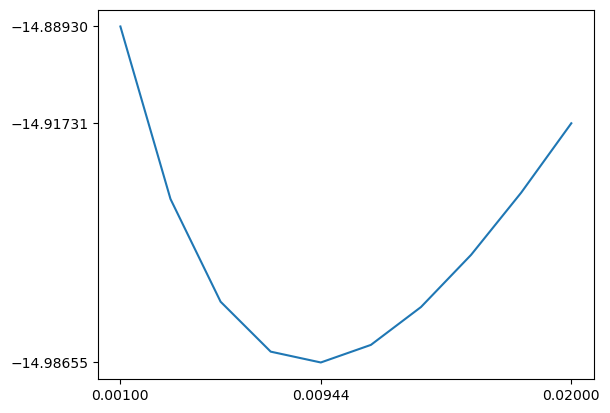

[0.009444444444444443] [-14.986549788382565]
-14.986549788382565 0.009444444444444443


In [5]:
mode_dbr, minimizer_s, eo_d = select_recursion_step_circuit(
    gci, mode_dbr_list = [DoubleBracketRotationType.group_commutator_third_order_reduced],times = np.linspace(1e-3,2e-2,10),please_be_visual = True)
print(gci.loss(minimizer_s, eo_d), minimizer_s)


In [6]:
print_vqe_comparison_report(gci)

VQE energy is -14.8569 and the DBQA yields -14.8569. 
The target energy is -15.27613 which means the difference is for VQE     0.41923 and of the DBQA 0.41923 which can be compared to the spectral gap 1.08767.
The relative difference is for VQE 2.74436%     and for DBQA 2.74436%.The energetic fidelity witness for the ground state for the VQE is 0.61456 and DBQA 0.61456


In [7]:
gci = execute_selected_recursion_step( gci, mode_dbr, minimizer_s, eo_d, please_be_verbose = True )

The boosting circuit used 0 CNOT gates coming from compiled XXZ evolution and 70 CZ gates from VQE.
For 10 qubits this gives n_CNOT/n_qubits = 0.0 and n_CZ/n_qubits = 7.0
VQE energy is -14.8569 and the DBQA yields -14.8569. 
The target energy is -15.27613 which means the difference is for VQE     0.41923 and of the DBQA 0.41923 which can be compared to the spectral gap 1.08767.
The relative difference is for VQE 2.74436%     and for DBQA 2.74436%.The energetic fidelity witness for the ground state for the VQE is 0.61456 and DBQA 0.61456
The boosting circuit used 90 CNOT gates coming from compiled XXZ evolution and 350 CZ gates from VQE.
For 10 qubits this gives n_CNOT/n_qubits = 9.0 and n_CZ/n_qubits = 35.0
VQE energy is -14.8569 and the DBQA yields -14.98655. 
The target energy is -15.27613 which means the difference is for VQE     0.41923 and of the DBQA 0.28958 which can be compared to the spectral gap 1.08767.
The relative difference is for VQE 2.74436%     and for DBQA 1.89565%.Th

In [8]:
gci.loss()

-14.986549788382565

-15.017770982266393


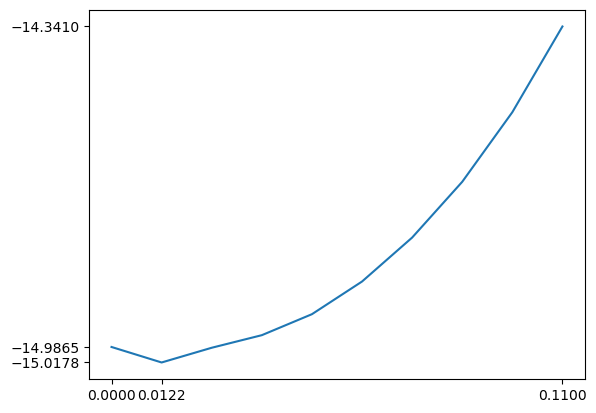

[0.01222222222248889] [-15.017770982266393]


In [9]:
mode_dbr, minimizer_s, eo_d = select_recursion_step_circuit(
    gci, mode_dbr_list = [DoubleBracketRotationType.group_commutator_third_order_reduced],times = np.linspace(3e-13,11e-2,10),please_be_visual = True)


In [10]:
execute_selected_recursion_step( gci, mode_dbr, minimizer_s, eo_d, please_be_verbose = True )


The boosting circuit used 90 CNOT gates coming from compiled XXZ evolution and 350 CZ gates from VQE.
For 10 qubits this gives n_CNOT/n_qubits = 9.0 and n_CZ/n_qubits = 35.0
VQE energy is -14.8569 and the DBQA yields -14.98655. 
The target energy is -15.27613 which means the difference is for VQE     0.41923 and of the DBQA 0.28958 which can be compared to the spectral gap 1.08767.
The relative difference is for VQE 2.74436%     and for DBQA 1.89565%.The energetic fidelity witness for the ground state for the VQE is 0.61456 and DBQA 0.73376
The boosting circuit used 540 CNOT gates coming from compiled XXZ evolution and 1750 CZ gates from VQE.
For 10 qubits this gives n_CNOT/n_qubits = 54.0 and n_CZ/n_qubits = 175.0
VQE energy is -14.8569 and the DBQA yields -15.01777. 
The target energy is -15.27613 which means the difference is for VQE     0.41923 and of the DBQA 0.25836 which can be compared to the spectral gap 1.08767.
The relative difference is for VQE 2.74436%     and for DBQA 1.6

In [15]:
from boostvqe.models.dbi.utils_gci_optimization import *

d_params_test, s, min_loss = gradient_descent_circuits(
gci,times_choose_step=np.linspace(1e-3,1e-2,10),
 train_epochs=5,
   d_params_init=eo_d.b_list,
   lr=10
)

-15.058537128524133
0


In [ ]:
c =Circuit(2)
c.add(gates.CNOT(0,1))
c.add(gates.RZ(1,theta = np.pi))
c.add(gates.CNOT(0,1))
u = c.unitary()

In [ ]:
u

array([[6.123234e-17-1.j, 0.000000e+00+0.j, 0.000000e+00+0.j,
        0.000000e+00+0.j],
       [0.000000e+00+0.j, 6.123234e-17+1.j, 0.000000e+00+0.j,
        0.000000e+00+0.j],
       [0.000000e+00+0.j, 0.000000e+00+0.j, 6.123234e-17+1.j,
        0.000000e+00+0.j],
       [0.000000e+00+0.j, 0.000000e+00+0.j, 0.000000e+00+0.j,
        6.123234e-17-1.j]])

In [ ]:
c =Circuit(1)
c.add(gates.RZ(0,theta = np.pi))
c.unitary()

array([[6.123234e-17-1.j, 0.000000e+00+0.j],
       [0.000000e+00+0.j, 6.123234e-17+1.j]])